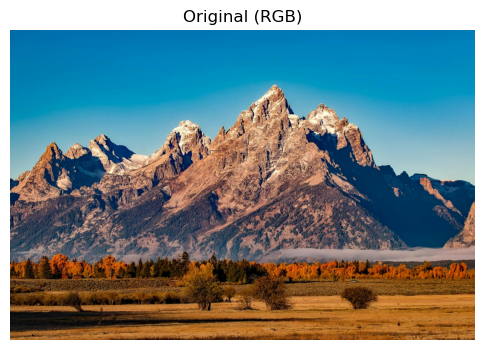

In [1]:
#  Smoothing an RGB color image with linear spatial filters

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- load (change this) ---
img_path = "../image2.jpg"

img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(img_path)

# keep an RGB copy for display; keep float copy for filtering math
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb_f32 = img_rgb.astype(np.float32) / 255.0

def show(img, title="", cmap=None, size=4):
    plt.figure(figsize=(size, size))
    if cmap is None:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

show(img_rgb, "Original (RGB)", size=6)


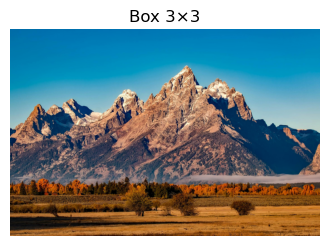

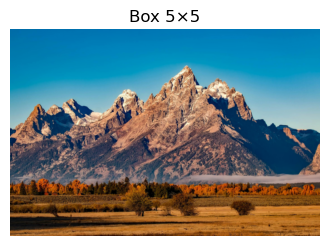

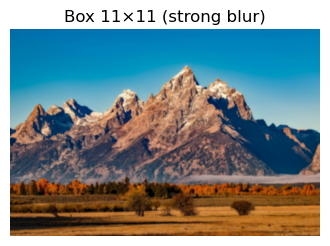

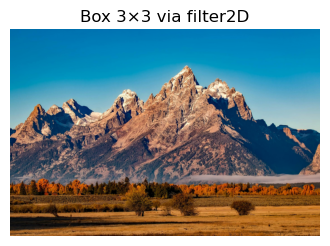

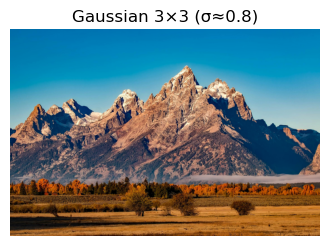

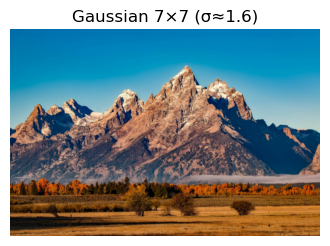

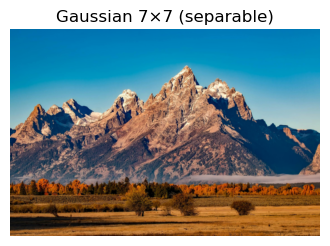

In [2]:
# %%
# Linear filters (box/mean and Gaussian) on COLOR image

def to_u8(img01):
    return np.clip(img01 * 255.0 + 0.5, 0, 255).astype(np.uint8)

# --- Box (mean) filters ---
box3  = cv2.blur(img_rgb_f32, (3,3), borderType=cv2.BORDER_REFLECT)
box5  = cv2.blur(img_rgb_f32, (5,5), borderType=cv2.BORDER_REFLECT)
box11 = cv2.blur(img_rgb_f32, (11,11), borderType=cv2.BORDER_REFLECT)

# same box filter via explicit kernel + filter2D (also linear)
k3 = np.ones((3,3), np.float32) / 9.0
box3_f2d = cv2.filter2D(img_rgb_f32, ddepth=-1, kernel=k3, borderType=cv2.BORDER_REFLECT)

# --- Gaussian filters (linear + separable) ---
gauss3 = cv2.GaussianBlur(img_rgb_f32, (3,3), sigmaX=0.8, borderType=cv2.BORDER_REFLECT)
gauss7 = cv2.GaussianBlur(img_rgb_f32, (7,7), sigmaX=1.6, borderType=cv2.BORDER_REFLECT)

# separable Gaussian using 1D kernels (for illustration; still linear)
# build a 1D Gaussian kernel of size 7, sigma=1.6 and apply with sepFilter2D
g1d = cv2.getGaussianKernel(ksize=7, sigma=1.6)  # column vector
gauss7_sep = cv2.sepFilter2D(img_rgb_f32, ddepth=-1, kernelX=g1d, kernelY=g1d, borderType=cv2.BORDER_REFLECT)

# convert back to uint8 for display
box3_u8, box5_u8, box11_u8 = to_u8(box3), to_u8(box5), to_u8(box11)
box3_f2d_u8 = to_u8(box3_f2d)
gauss3_u8, gauss7_u8, gauss7_sep_u8 = to_u8(gauss3), to_u8(gauss7), to_u8(gauss7_sep)

# visualize
show(box3_u8,  "Box 3×3")
show(box5_u8,  "Box 5×5")
show(box11_u8, "Box 11×11 (strong blur)")
show(box3_f2d_u8, "Box 3×3 via filter2D")
show(gauss3_u8, "Gaussian 3×3 (σ≈0.8)")
show(gauss7_u8, "Gaussian 7×7 (σ≈1.6)")
show(gauss7_sep_u8, "Gaussian 7×7 (separable)")


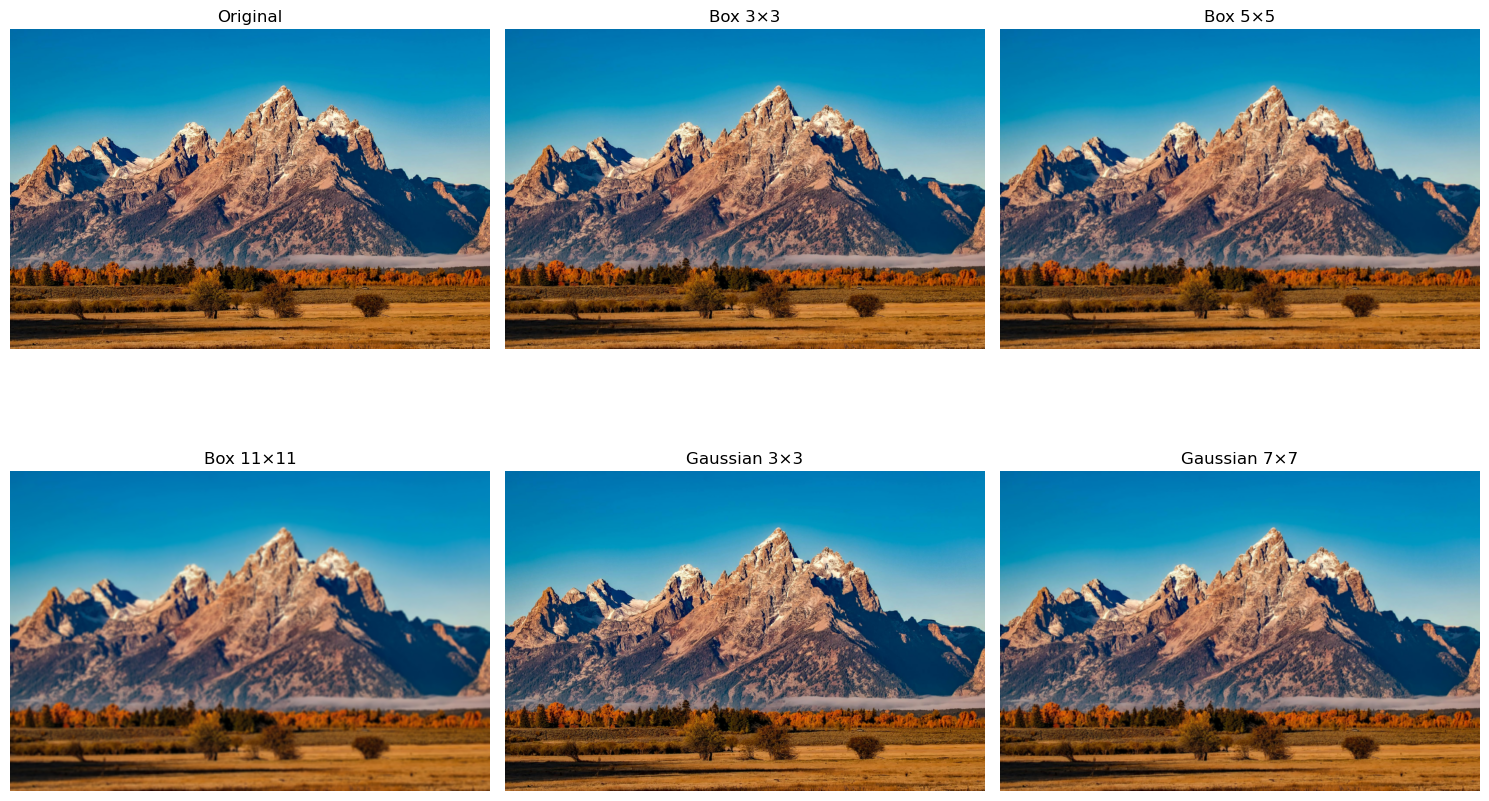

In [3]:
# %%
# Side-by-side grid for quick comparison

pairs = [
    ("Original", img_rgb),
    ("Box 3×3", box3_u8),
    ("Box 5×5", box5_u8),
    ("Box 11×11", box11_u8),
    ("Gaussian 3×3", gauss3_u8),
    ("Gaussian 7×7", gauss7_u8),
]

cols = 3
rows = int(np.ceil(len(pairs)/cols))
plt.figure(figsize=(15, 5*rows))
for i, (name, im) in enumerate(pairs, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(im)
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()


PSNR (noisy vs original):      26.36 dB
PSNR (box5 denoise vs original): 24.82 dB
PSNR (gauss7 denoise vs original): 26.65 dB


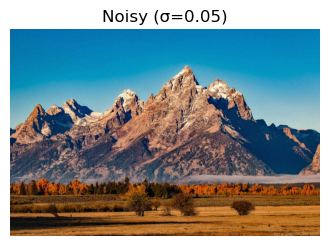

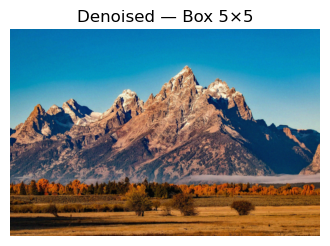

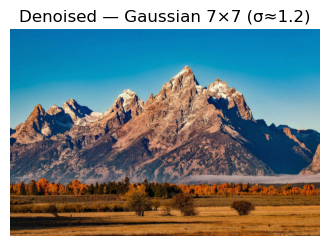

In [4]:
# %%
# (Optional) Evaluate smoothing as DENOISING on a noisy version
# Add Gaussian noise, then compare PSNR before/after linear smoothing.

def add_gaussian_noise(img01, sigma=0.05, seed=0):
    rng = np.random.default_rng(seed)
    noisy = img01 + rng.normal(0, sigma, img01.shape).astype(np.float32)
    return np.clip(noisy, 0, 1)

def psnr(ref01, test01):
    mse = np.mean((ref01 - test01)**2)
    if mse <= 1e-12:
        return 99.0
    return 10.0 * np.log10(1.0 / mse)

noisy = add_gaussian_noise(img_rgb_f32, sigma=0.05, seed=42)
den_box5   = cv2.blur(noisy, (5,5), borderType=cv2.BORDER_REFLECT)
den_gauss7 = cv2.GaussianBlur(noisy, (7,7), sigmaX=1.2, borderType=cv2.BORDER_REFLECT)

print(f"PSNR (noisy vs original):      {psnr(img_rgb_f32, noisy):.2f} dB")
print(f"PSNR (box5 denoise vs original): {psnr(img_rgb_f32, den_box5):.2f} dB")
print(f"PSNR (gauss7 denoise vs original): {psnr(img_rgb_f32, den_gauss7):.2f} dB")

show(to_u8(noisy), "Noisy (σ=0.05)")
show(to_u8(den_box5), "Denoised — Box 5×5")
show(to_u8(den_gauss7), "Denoised — Gaussian 7×7 (σ≈1.2)")
